<!--BOOK_INFORMATION-->
*This notebook contains an excerpt from the <a href="http://shop.oreilly.com/product/0636920034919.do">Python Data Science Handbook</a> by Jake VanderPlas; the content is available on <a href="https://github.com/jakevdp/PythonDataScienceHandbook">GitHub</a>.*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

Adapded for class presentation by Claudio Sartori - University of Bologna

# Introducing Scikit-Learn

<a href="http://scikit-learn.org">Scikit-Learn</a>
- package that provides efficient versions of a large number of common algorithms
- clean, uniform, and streamlined API
- very useful and complete online documentation.
    - once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is very straightforward
    
## Contents

- *Estimator* API
- *Examples*

In [1]:
import seaborn as sns
import pandas as pd
train_size = 0.67
random_state = 42 # any positive integer is acceptable, it is necessary for **reproducibility

In [9]:
df = pd.read_csv("../Lab on topic 03a - Classification with Decision Trees-20241201/iris.csv", names=["sepal length","sepal width","petal length","petal width","class"])

In [10]:
df.head()


,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Features matrix

The part of the data matrix containing the ``unsupervised attributes``

Usually in *scikit-learn* documentation referred as ``X``

Can be a:
- two-dimensional numpy array with shape ``[n_samples, n_features]``
- SciPy ``sparse matrix``
- Pandas ``DataFrame``

The matrix cases require uniform data types in columns


#### Target array

*label* or *target* array, by convention usually called ``y``
- usually one dimensional, with length ``n_samples``, 
- generally contained in a NumPy array or Pandas ``Series``.
- may have continuous numerical values, or discrete classes/labels
- usually it the quantity we want to *predict from the data*
    - in statistical terms, it is the dependent variable

In the example we may wish to construct a model that can predict the species of flower based on the other measurements

The measurements of the flower components are the ``features array``

The ``class`` column can be considered the target array

Assign the target column name to a variable `target

### Visualization

Use Seaborn (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)) to visualize the data

Below we need to prepare the environment for plotting information on the dataset.

1. issue the command `%matplotlib inline` In this way, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
2. import `seaborn` giving it the 'nickname' `sns`
3. call the `pairplot` function of `seaborn` on the `iris` dataset, with parameters 
    - `hue = target`, this sets the meaning of the color in the plot of the points of the dataset
    - `height = 2`, this sets the size of the plots
    
--> insert your code in a new cell below this one

In [11]:
import seaborn as sns
%matplotlib inline

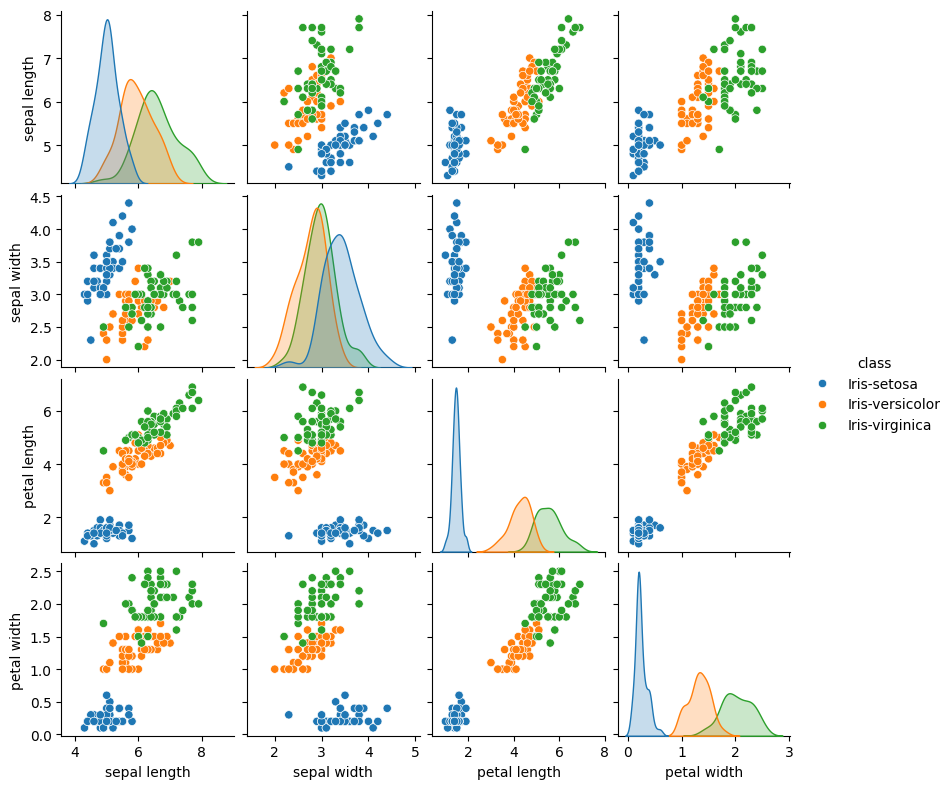

In [15]:
sns.pairplot(df,hue="class",height=2);

For use in Scikit-Learn, we will extract the features matrix and target array from the ``DataFrame``. We can do this using some of the Pandas ``DataFrame`` operations discussed in the [Chapter 3](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html) of the above mentioned book.

For example, the `.drop` method allows to drop a column or row by name; remember to specify the axis to use, which is 1 for columns.

### Preparing features and target
Store in X the content of `iris` excluding the column `class`. Verify the shape

--> insert your code in a new cell below this one

In [20]:
X = df.drop("class",axis=1)
X.shape

(150, 4)

Store in `y` the `target` of `iris`. Verify the shape

--> insert your code in a new cell below this one

In [22]:
y = df["class"]
y.shape

(150,)

To summarize, the expected layout of features and target values is visualized in the following diagram:
![Figure](figures/05.02-samples-features.png "Features and target")
With this data properly formatted, we can move on to consider the estimator API of Scikit-Learn:

## Scikit-Learn's Estimator API

The Scikit-Learn API is designed with the following guiding principles in mind, as outlined in the [Scikit-Learn API paper](http://arxiv.org/abs/1309.0238):

- *Consistency*: All objects share a common interface drawn from a limited set of methods, with consistent documentation.

- *Inspection*: All specified parameter values are exposed as public attributes.

- *Limited object hierarchy*: Only algorithms are represented by Python classes; datasets are represented
  in standard formats (NumPy arrays, Pandas ``DataFrame``s, SciPy sparse matrices) and parameter
  names use standard Python strings.

- *Composition*: Many machine learning tasks can be expressed as sequences of more fundamental algorithms,
  and Scikit-Learn makes use of this wherever possible.

- *Sensible defaults*: When models require user-specified parameters, the library defines an appropriate default value.

In practice, these principles make Scikit-Learn very easy to use, once the basic principles are understood.
Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

## Hyperparameters
The machine learning algorithms are designed to learn from the data the _parameters_ that will be used at run time by the algorithms implementing the tasks to perform at the best on data similar to those used in learning. 

For example, a _decision tree_ (and in particular all the tests placed in the nodes) are the parameters of a _decision tree classifier_

The learning process is also controlled by other parameters (e.g. to control the _overfitting_ ) which cannot be direcly learned from the data, but are chosen _before_ the learning process. Those are called __hyperparameters__

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
    - or in the first attempt use the default values
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through several simple examples of applying supervised and unsupervised learning methods.

### Supervised learning example: Iris classification

Let's take a look at another example of this process, using the Iris dataset we discussed earlier.
Our question will be this: given a model trained on a portion of the Iris data, how well can we predict the remaining labels?

For this task, we will use the _Decision Tree_ algorithm, with the standard parameter values.
We would like to evaluate the model on data it has not seen before, and so we will split the data into a *training set* and a *testing set*.
This could be done by hand, but it is more convenient to use the ``train_test_split`` utility function

1. Import the method `train_test_split` from `sklearn.model_selection`<br>
2. Generate the variables `Xtrain, Xtest, ytrain, ytest` by calling the function `train_test_split` with parameters `X` and `y`, and the additional parameter `random_state`, this must be set to a positive integer, for reproducibility<br>
3. Show the shape of the resulting variables<br>


--> insert your code in a new cell below this one

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = random_state, train_size=train_size)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 4), (50, 4), (100,), (50,))

With the data arranged, we can follow our recipe to predict the labels:
1. choose the model class, it will be `DecisionTreeClassifier`, imported from `sklearn.tree`<br>
2. instantiate the `model` as a `DecisionTreeClassifier` whithout any hyperparameter, we will use the defaults<br>
3. fit the `model` to data, calling its method `fit` with parameters `Xtrain, ytrain`<br>
4. predict the target `ytrain_dt` using the `predict` method of `model` on the `Xtrain` data

--> insert your code in a new cell below this one

In [30]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_train_dt = model.predict(X_train)

We can use the ``accuracy_score`` utility to see the fraction of predicted training set labels that match their true value.

Import the `accuracy_score` from `sklearn.metrics` and call it on `ytrain, ytrain_dt`

--> insert your code in a new cell below this one

In [43]:
from sklearn.metrics import accuracy_score
accuracy_train_dt = accuracy_score(y_train,y_train_dt)
print(f"The accuracy on training set is {(accuracy_train_dt*100)}%")

The accuracy on training set is 100.0%


Finally, predict the new target `ytest_dt` using the `predict` method of `model` on the `Xtest` data, then compute the accuracy on the test set

--> insert your code in a new cell below this one

In [45]:
y_test_dt = model.predict(X_test)
accuracy_test_dt = accuracy_score(y_test,y_test_dt)
print(f"The accuracy on training set is {(accuracy_test_dt*100)}%")

The accuracy on training set is 98.0%


## Show the Decision Tree
To show the Decision Tree we will need a few imports

`from matplotlib import pyplot`<br>
`from sklearn.tree import plot_tree`<br>
`from matplotlib.pyplot import figure`

We will start setting the _figure size_ with the `figure` function, taking as argument `figsize` and a list of two values in inches, try and error for the measures you like.

We will then use the `plot_tree` function of `sklearn.tree`. It takes as argument the *fitted model*\, in our case `model` and several arguments to control how the tree is displayed.

I suggest the arguments below, you can try freely configurations and omissions of the parameters, to use the defaults. The parameters must follow the model variable and be separated by commas, the order is not relevant, since the parameters are named.

`filled=True`<br>
`feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']`<br>
`class_names = ['setosa', 'versicolor', 'virginica']`<br>
`rounded = True`<br>
`proportion = True`<br>

--> insert your code in a new cell below this one

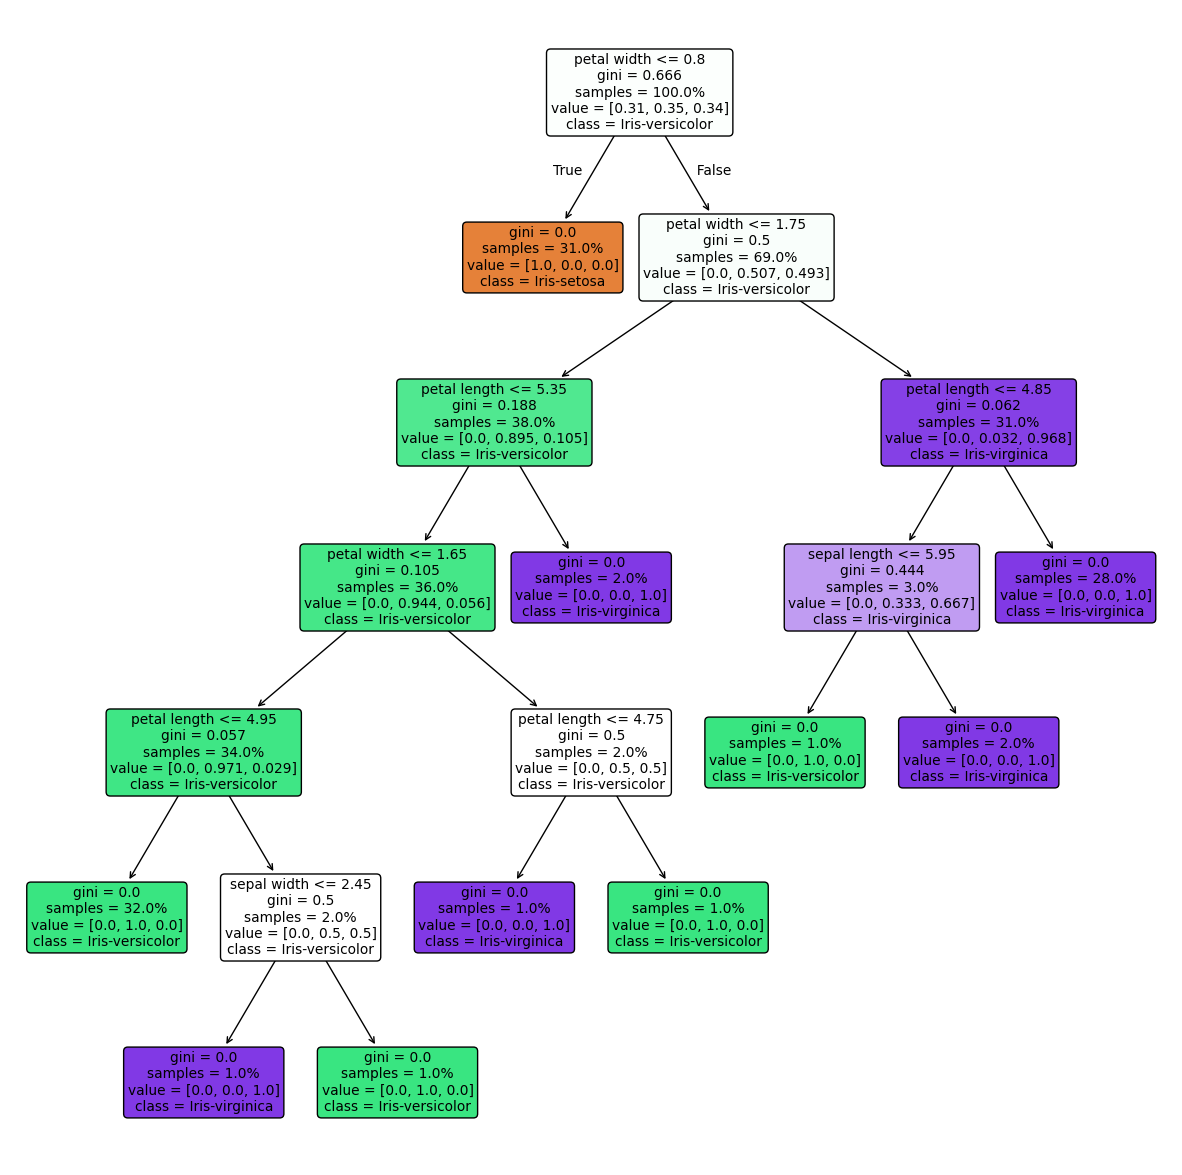

In [53]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(15,15))
plot_tree(model,filled=True,feature_names=X_train.columns,class_names=list(y.unique()),rounded=True,proportion=True)
plt.show()